<a href="https://colab.research.google.com/github/janiosl/python.ds/blob/master/arangoDB/BD_g01_ArangoDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CEFET-RJ**

**Programa de Pós-Gradução em Ciência da Computação - PPCIC**

**Mestrado em Ciência da Computação**

**Disciplina: Banco de Dados - 2021/1**

* **Trabalho Final**: Implementação e Análise Análise Crítica do Banco de Dados ArangoDB
* **Professor**: Jorge de Abreu Soares
* **Alunos**: Cristiane Géa, Janio de Souza Lima e Tácito Braga Araripe





**OBSERVAÇÃO**:

Este notebook, sobretudo nas seções 1 e 2, é uma adaptação com tradução para português e algumas adaptações de código feitas a partir dos tutoriais oficiais do ArangoDB disponíveis na área de aprendizagem cujo link está listado na seção de Referências. Seu objetivo é apresentar uma visão inicial básica tanto do ArangoDB quanto de sua forma de integração com Python através de uma API. Detalhes sobre outras formas de uso do ArangoDB, inclusive sua instalação e configuração através da interface web, bem como execução do benchmark de avaliação estão registrados na apresentação e relatório técnico da disciplina Banco de Dados.

#1 Preparação do ambiente

In [1]:
import platform
print('Plataforma usada no experimento')
print('='*40)

print('Google Colab')
print(f'Processador: {platform.processor()}')
print(f'SO: {platform.system()}')

#Consulta simplificada da plataforma
p = platform.platform()
print('\nVersão do SO:')
for item in p.split('-'):
  print(item, end=' ')

Plataforma usada no experimento
Google Colab
Processador: x86_64
SO: Linux

Versão do SO:
Linux 5.4.109+ x86_64 with Ubuntu 18.04 bionic 

* Instalações e importações

In [2]:
%%capture
!git clone https://github.com/joerg84/ArangoDBUniversity.git
!rsync -av ArangoDBUniversity/ ./ --exclude=.git
!pip3 install pyarango
!pip3 install "python-arango>=5.0"

In [3]:
import json
import requests
import sys
import oasis
import time

from pyArango.connection import *
from arango import ArangoClient

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


* **Banco de Dados e Credenciais Temporárias**

Note que nessa etapa estão sendo criadas credenciais temporárias da plataforma de tutoriais do ArangoDB. Em uma situação de uso real, deveria ser criada a variável login com as credenciais reais para conexão ao banco de dados desejado.

In [4]:
#Banco de Dados Temporário
# Retrieve tmp credentials from ArangoDB Tutorial Service
login = oasis.getTempCredentials(tutorialName="AQLCrudTutorial",
                                 credentialProvider='https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB')

# Connect to the temp database
conn = oasis.connect(login)
db = conn[login["dbName"]] 

Requesting new temp credentials.
Temp database ready to use.


* **Exibição das credenciais criadas**

Complementando as observações anteriores, veja que a variável login é um dicionário Python no qual são armazenados os valores para as chaves nome do usuário, senha e banco de dados (username, password e dbName).

In [5]:
print("https://{}:{}".format(login["hostname"], login["port"]))
print("Usuário: " + login["username"])
print("Senha: " + login["password"])
print("Database: " + login["dbName"])

https://tutorials.arangodb.cloud:8529
Usuário: TUTqyk9s2jks4axoqya8agyq
Senha: TUTdn82juu7i7a4kr6v14bg
Database: TUTcvysl2kp0jvid45g30oa9o


In [6]:
print(type(login), login, sep='\n')

<class 'dict'>
{'dbName': 'TUTcvysl2kp0jvid45g30oa9o', 'username': 'TUTqyk9s2jks4axoqya8agyq', 'password': 'TUTdn82juu7i7a4kr6v14bg', 'hostname': 'tutorials.arangodb.cloud', 'port': 8529}


#2 Criando e analisando dados com AQL

* **Criando a "Collection" no banco de dados**

Coleções são a forma de armazenamento dos dados em uma base de dados ArangoDB. Elas são manipuladas através da linguagens NoSQL Arango Query Language (AQL). A instrução abaixo cria uma coleção e é possível relacionar com as instruções DDL das linguagens SQL. Neste exemplo será criada uma base de dados para simular dados de personagens da série "*Game of Thrones*".

In [7]:
#Criação de uma Collection na base de dados "dbName"
db.createCollection(name="Characters")

ArangoDB collection name: Characters, id: 3727297470, type: document, status: loaded

* **Inserção de registros na coleção**

A instrução `INSERT` permite a inserção de registros individuais na coleção criada na etapa anterior. Para isso é usada uma sintaxe de chave-valor - similar aos dicionários de dados do Python - em que a primeira string é a chave que dá nome ao atributo na base de dados, em seguida é usado o caractere ":" e passo o valor daquele atributo que pode ter os tipos a seguir:

* null => Valores Nulos
* boolean (true, false) => Valores lógico (verdadeiro ou falso)
* number (integer and floating point) => Números (tanto inteiros quanto de pontos flutuante)
* string => Cadeia de caracteres em texto
* array => Matrizes
* object => Objetos

Por exemplo para inserir um atributo para o nome de um cliente e seu CPF em uma coleção denominada Clientes, poderia ser usada a seguinte instrução:

```
INSERT {
  "nome": "João Ninguém",
  "CPF": "00000000012"
  } INTO Clientes
```

In [8]:
#Uso da instrução INSERT para criar um registro na coleção Characters
insert_query = """
INSERT {
    "name": "Ned",
    "surname": "Stark",
    "alive": true,
    "age": 41,
    "traits": ["A","H","C","N","P"]
} INTO Characters
"""

db.AQLQuery(insert_query)

* Realização de uma consulta simples (todos os registros da coleção)

In [9]:
all_characters = """
FOR c IN Characters
    RETURN c
"""

query_result = db.AQLQuery(all_characters, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

{'_key': '3727297472', '_id': 'Characters/3727297472', '_rev': '_cWYUJQu---', 'age': 41, 'alive': True, 'name': 'Ned', 'surname': 'Stark', 'traits': ['A', 'H', 'C', 'N', 'P']}



* **Inserção manual de múltiplos registros**

A linguagem AQL não permite a inserção direta de múltiplos registros, por isso está sendo realizada a inserção em duas etapas na célula de código a seguir. A primeira `LET data = [...]` cria os dados como uma variável e a segunda usa um loop `FOR` para iterar inserções individuais para cada registro na variável `data`.
OBSERVAÇÃO: Note que estas instruções são todas em AQL uma vez que o Python está apenas encapsulando a query na variável `insert_query` que é passada para API do ArangoDB através do método `AQLQuery`.

In [10]:
insert_query = """
LET data = [
    { "name": "Robert", "surname": "Baratheon", "alive": false, "traits": ["A","H","C"] },
    { "name": "Jaime", "surname": "Lannister", "alive": true, "age": 36, "traits": ["A","F","B"] },
    { "name": "Catelyn", "surname": "Stark", "alive": false, "age": 40, "traits": ["D","H","C"] },
    { "name": "Cersei", "surname": "Lannister", "alive": true, "age": 36, "traits": ["H","E","F"] },
    { "name": "Daenerys", "surname": "Targaryen", "alive": true, "age": 16, "traits": ["D","H","C"] },
    { "name": "Jorah", "surname": "Mormont", "alive": false, "traits": ["A","B","C","F"] },
    { "name": "Petyr", "surname": "Baelish", "alive": false, "traits": ["E","G","F"] },
    { "name": "Viserys", "surname": "Targaryen", "alive": false, "traits": ["O","L","N"] },
    { "name": "Jon", "surname": "Snow", "alive": true, "age": 16, "traits": ["A","B","C","F"] },
    { "name": "Sansa", "surname": "Stark", "alive": true, "age": 13, "traits": ["D","I","J"] },
    { "name": "Arya", "surname": "Stark", "alive": true, "age": 11, "traits": ["C","K","L"] },
    { "name": "Robb", "surname": "Stark", "alive": false, "traits": ["A","B","C","K"] },
    { "name": "Theon", "surname": "Greyjoy", "alive": true, "age": 16, "traits": ["E","R","K"] },
    { "name": "Bran", "surname": "Stark", "alive": true, "age": 10, "traits": ["L","J"] },
    { "name": "Joffrey", "surname": "Baratheon", "alive": false, "age": 19, "traits": ["I","L","O"] },
    { "name": "Sandor", "surname": "Clegane", "alive": true, "traits": ["A","P","K","F"] },
    { "name": "Tyrion", "surname": "Lannister", "alive": true, "age": 32, "traits": ["F","K","M","N"] },
    { "name": "Khal", "surname": "Drogo", "alive": false, "traits": ["A","C","O","P"] },
    { "name": "Tywin", "surname": "Lannister", "alive": false, "traits": ["O","M","H","F"] },
    { "name": "Davos", "surname": "Seaworth", "alive": true, "age": 49, "traits": ["C","K","P","F"] },
    { "name": "Samwell", "surname": "Tarly", "alive": true, "age": 17, "traits": ["C","L","I"] },
    { "name": "Stannis", "surname": "Baratheon", "alive": false, "traits": ["H","O","P","M"] },
    { "name": "Melisandre", "alive": true, "traits": ["G","E","H"] },
    { "name": "Margaery", "surname": "Tyrell", "alive": false, "traits": ["M","D","B"] },
    { "name": "Jeor", "surname": "Mormont", "alive": false, "traits": ["C","H","M","P"] },
    { "name": "Bronn", "alive": true, "traits": ["K","E","C"] },
    { "name": "Varys", "alive": true, "traits": ["M","F","N","E"] },
    { "name": "Shae", "alive": false, "traits": ["M","D","G"] },
    { "name": "Talisa", "surname": "Maegyr", "alive": false, "traits": ["D","C","B"] },
    { "name": "Gendry", "alive": false, "traits": ["K","C","A"] },
    { "name": "Ygritte", "alive": false, "traits": ["A","P","K"] },
    { "name": "Tormund", "surname": "Giantsbane", "alive": true, "traits": ["C","P","A","I"] },
    { "name": "Gilly", "alive": true, "traits": ["L","J"] },
    { "name": "Brienne", "surname": "Tarth", "alive": true, "age": 32, "traits": ["P","C","A","K"] },
    { "name": "Ramsay", "surname": "Bolton", "alive": true, "traits": ["E","O","G","A"] },
    { "name": "Ellaria", "surname": "Sand", "alive": true, "traits": ["P","O","A","E"] },
    { "name": "Daario", "surname": "Naharis", "alive": true, "traits": ["K","P","A"] },
    { "name": "Missandei", "alive": true, "traits": ["D","L","C","M"] },
    { "name": "Tommen", "surname": "Baratheon", "alive": true, "traits": ["I","L","B"] },
    { "name": "Jaqen", "surname": "H'ghar", "alive": true, "traits": ["H","F","K"] },
    { "name": "Roose", "surname": "Bolton", "alive": true, "traits": ["H","E","F","A"] },
    { "name": "The High Sparrow", "alive": true, "traits": ["H","M","F","O"] }
]

FOR d IN data
    INSERT d INTO Characters
"""

db.AQLQuery(insert_query)

* Conferência do novo estado da coleção

In [11]:
#Consultando o novo estado da coleção e retornando apenas o atributo name
all_characters_names = """
FOR c IN Characters
    RETURN c.name
"""

query_result = db.AQLQuery(all_characters_names, rawResults=True)

"""
#Exibição da query completa
for doc in  query_result:
    print(doc, sep='\n')
"""

#Exibição dos primeiros 10 registros da query
for i in range(10):
  print(query_result[i])

Ned
Robert
Jaime
Catelyn
Cersei
Daenerys
Jorah
Petyr
Viserys
Jon


* **Consultas condicionais**

Nas células de código a seguir usamos as instruções `FILTER`, `SORT` e `LIMIT` para realizar consultas com uso de condições, ordenação e limitação da quantidade de reultados.

In [12]:
#Filtrando por personagens que não estão vivos
find_ned_query = """
FOR c IN Characters
    FILTER c.alive == false
    RETURN c.name
"""
query_result = db.AQLQuery(find_ned_query, rawResults=True)
for doc in  query_result:
    print(doc, sep='\n')

Robert
Catelyn
Jorah
Petyr
Viserys
Robb
Joffrey
Khal
Tywin
Stannis
Margaery
Jeor
Shae
Talisa
Gendry
Ygritte


In [13]:
#Filtrando por personagens com idade maior que 18 anos e não estão vivos
find_ned_query = """
FOR c IN Characters
    FILTER c.alive == false AND c.age >= 18
    RETURN c.name
"""
query_result = db.AQLQuery(find_ned_query, rawResults=True)
for doc in  query_result:
    print(doc, sep='\n')

Catelyn
Joffrey


In [14]:
#Filtrando por personagens com idade maior que 18 anos e não estão vivos
#Alterando os atributos exibidos no retorno
find_ned_query = """
FOR c IN Characters
    FILTER c.alive == false AND c.age >= 18
    RETURN { Nome: c.name, Sobrenome: c.surname, Idade: c.age }
"""
query_result = db.AQLQuery(find_ned_query, rawResults=True)
for doc in  query_result:
    print(doc, sep='\n')

{'Nome': 'Catelyn', 'Sobrenome': 'Stark', 'Idade': 40}
{'Nome': 'Joffrey', 'Sobrenome': 'Baratheon', 'Idade': 19}


In [15]:
#Filtrando por sobrenome (surname)
find_ned_query = """
FOR c IN Characters
    FILTER c.surname == "Bolton"
    RETURN c
"""
query_result = db.AQLQuery(find_ned_query, rawResults=True)
for doc in  query_result:
    print(doc, sep='\n')

{'_key': '266248622266', '_id': 'Characters/266248622266', '_rev': '_cWYUJb2--W', 'name': 'Ramsay', 'surname': 'Bolton', 'alive': True, 'traits': ['E', 'O', 'G', 'A']}
{'_key': '266248622272', '_id': 'Characters/266248622272', '_rev': '_cWYUJb2--i', 'name': 'Roose', 'surname': 'Bolton', 'alive': True, 'traits': ['H', 'E', 'F', 'A']}


In [16]:
#Limitando a quantidade de saídas na própria consulta
sample_chars_query = """
FOR c IN Characters
    LIMIT 5
    RETURN c.name
"""
query_result = db.AQLQuery(sample_chars_query, rawResults=True)
for doc in  query_result:
    print(doc, sep='\n')

Ned
Robert
Jaime
Catelyn
Cersei


In [17]:
#Ordenado a consulta e depois limitando a quantidade de saídas
sample_chars_query = """
FOR c IN Characters
    SORT c.name
    LIMIT 5
    RETURN { name: c.name, surname: c.surname, age: c.age }
"""
query_result = db.AQLQuery(sample_chars_query, rawResults=True)
for doc in  query_result:
    print(doc, sep='\n')

{'name': 'Arya', 'surname': 'Stark', 'age': 11}
{'name': 'Bran', 'surname': 'Stark', 'age': 10}
{'name': 'Brienne', 'surname': 'Tarth', 'age': 32}
{'name': 'Bronn', 'surname': None, 'age': None}
{'name': 'Catelyn', 'surname': 'Stark', 'age': 40}


#3 Excluindo dados

* Removendo todos os dados

In [18]:
remove_all = """
FOR c IN Characters
    REMOVE c IN Characters
"""
db.AQLQuery(remove_all, rawResults=False)

In [19]:
#Verificando o resultado da remoção
all_characters_names = """
FOR c IN Characters
    RETURN c
"""

query_result = db.AQLQuery(all_characters_names, rawResults=True)
if len(query_result) == 0 :
    print("No characters left.")

No characters left.


#4 Reprodução Benchmark ArangoDB (2018)

Nessa seção apresentamos uma visão sintética da reprodução do Benchmark Arango DB 2018 [Weinberger, 2018]. Neste experimento, realizado pela própria ArangoDB, são comparados os resultados de desempenho do SGBD em diferentes cenários com outras soluções NoSQL. A figura 1 a seguir apresenta a visualização resumida dos resultados, indicando um desempenho superior em alguns cenários e mesmo nos cenários em que não tem o melhor resultado está entre as soluções melhores ou intermediárias.

![](https://www.arangodb.com/wp-content/uploads/2018/02/UPDATE-Benchmark-2018.001.jpeg)

Figura 1 - Benchmark Arango DB [Weinberger, 2018]

A execução do benchmark não foi realizada nesse notebbok, tendo em vista que a reprodutibilidade nesse ambiente levaria à necessidade de diversos ajustes. Dessa forma, escolheu-se reproduzir o experimento de execução do benchmark usando os scripts fornecidos pelo repositório https://github.com/weinberger/nosql-tests em um ambiente local com sistema operacional Linux Ubuntu 18.04.

A célula a seguir carrega os resultados do experimento realizado.

In [20]:
import pandas as pd

In [21]:
#Carga do relatório com resultados da execução do benchmark
arquivo = 'https://github.com/janiosl/python.ds/raw/master/arangoDB/results/result_raw.xlsx'
results = pd.read_excel(arquivo, sheet_name='raw_tabular')

A tabela carregada abaixo apresenta os resultados dos testes realizados. O script fornecido pelo repositório realiza outros testes e esse trabalho foi realizado executando os testes com os parâmetros padrão das funções executadas, exceto pela seleção dos bancos do banco de dados ArangoDB, para evitar repetir os testes para todos os bancos de dados, tendo em vista delimitação do escopo do trabalho. Após a execução foram armazenados tabulados os resultados apenas para os testes citados no artigo de apresentação do benchmark (), conforme listados a seguir:

* Single read
* Single write
* Single write Sync
* Aggregation
* Neighbors second
* Neighbors second with data
* Shortest path

---

Na exibição tabular a seguir, temos primeiramente a visualização do tempo em segundos para cada teste realizado. As colunas 0 e 1 apresentam respectivamente os resultados para o ArangoDB e Arango DB MMFILES (EXPLICAR). Por sua vez, as colunas identificadas como 2 e 3 na segunda tabela apresentam os resultados relativos usando ArangoDB como base, ou seja, com 1 (100%) e o ArangoDB MMFILES como a proporção de tempo que este levou em relação à base.

In [22]:
#Resultados absolutos (segundos)
results.iloc[0:2, :].transpose()

,0,1
SGBD,ArangoDB (s),ArangoDB MMFILES (s)
SINGLE_READ,7.985,7.975
SINGLE_WRITE,9.705,9.835
SINGLE_WRITE_SYNC,20.175,19.717
AGGREGATION,1.68,0.566
NEIGHBORS_2,1.129,1.146
NEIGHBORS_2ND_DATA,2.602,2.582
SHORTEST,0.206,0.544


In [23]:
#Resultados relativos (1 = 100%)
results.iloc[2:4, :].transpose()

,2,3
SGBD,ArangoDB (p),ArangoDB MMFILES (p)
SINGLE_READ,1,0.998748
SINGLE_WRITE,1,1.0134
SINGLE_WRITE_SYNC,1,0.977299
AGGREGATION,1,0.336905
NEIGHBORS_2,1,1.01506
NEIGHBORS_2ND_DATA,1,0.992314
SHORTEST,1,2.64078


A seguir são exibidas duas visualizações dos valores obtidos nos testes. No primeiro gráfico temos os valores absolutos (em segundos) para cada teste realizado. Na sequência é apresentado o gráfico com o valor relativo entre os dois benchmarks do ArangoDB.

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [29]:
results_raw = pd.read_excel(arquivo, sheet_name='raw')

In [30]:
s = results_raw[results_raw.METRIC == 's']
s.set_index('SGBD_AND_METRIC', inplace=True)
s = s.iloc[:, 1:]

#Separação dos dados em variáveis
labels_S = list(results.keys()[1:])
adbS = list(s.loc['ArangoDB (s)'].VALUE)
mmfS = list(s.loc['ArangoDB MMFILES (s)'].VALUE)

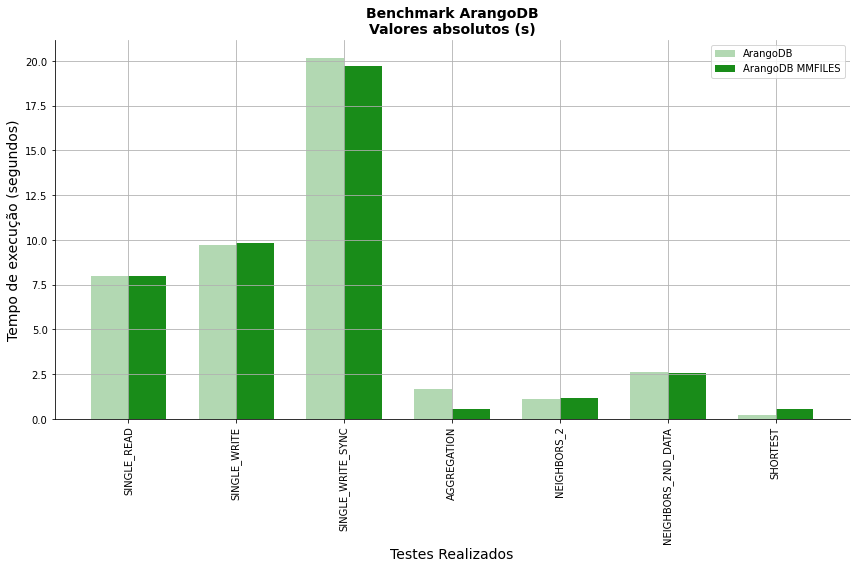

In [31]:
x = np.arange(len(labels_S))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots()

plt.grid()
fig.set_size_inches(12,8)

rects1 = ax.bar(x - width/2, adbS, width, label='ArangoDB', color='green', alpha=0.3)
rects2 = ax.bar(x + width/2, mmfS, width, label='ArangoDB MMFILES', color='green', alpha=0.9)

ax.set_ylabel('Tempo de execução (segundos)', fontsize=14)
ax.set_xlabel('Testes Realizados', fontsize=14)

ax.set_title('Benchmark ArangoDB\nValores absolutos (s)', fontsize=14, fontweight ='bold')

ax.set_xticks(x)
ax.set_xticklabels(labels_S, rotation='vertical')

ax.legend()
sns.despine()

fig.tight_layout()

Se compararmos os valores obtidos com aqueles do benchmark, percebemos que a execução obteve valores no geral menores do que nos testes originais. As diferenças são mais acentuadas nos tests de leitura e escrita simples (single read e single write). Na avaliação dos valores percentuais a proporção entre o ArangoDB e ArangoDB MMFiles se mantém estável, exceto por alguns casos pontuais, principalmente no teste "*shortest*", cuja diferente caiu de 816% para 264%.

![](https://www.arangodb.com/wp-content/uploads/2018/02/UPDATE-Performance-Benchmark-2018-Overview-Table.jpg)

Fonte:  Benchmark Arango DB [Weinberger, 2018]

In [32]:
#Reoranização dos dados para geração da visualização
p = results_raw[results_raw.METRIC == 'p']
p.set_index('SGBD_AND_METRIC', inplace=True)
p = p.iloc[:, 1:]

#Separação dos dados em variáveis
labels = list(results.keys()[1:])
adb = list(p.loc['ArangoDB (p)'].VALUE)
mmf = list(p.loc['ArangoDB MMFILES (p)'].VALUE)

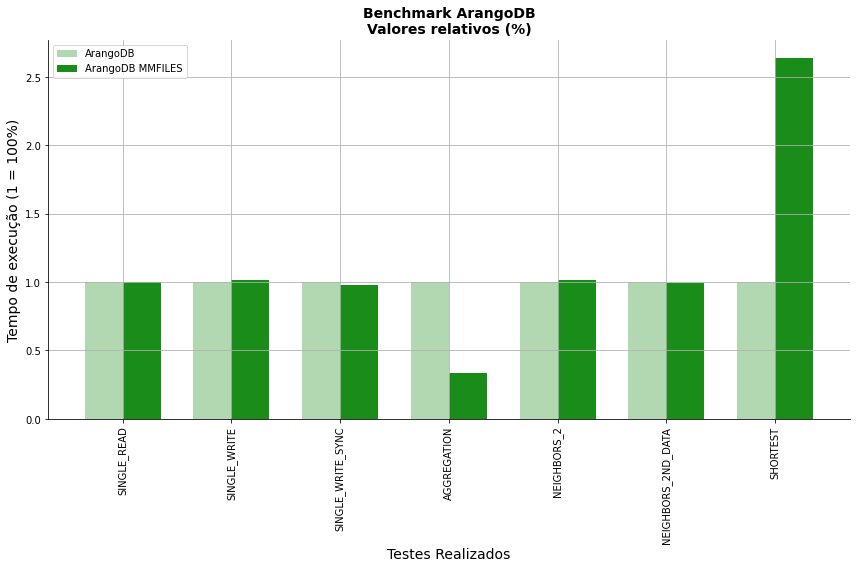

In [33]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots()

plt.grid()
fig.set_size_inches(12,8)

rects1 = ax.bar(x - width/2, adb, width, label='ArangoDB', color='green', alpha=0.3)
rects2 = ax.bar(x + width/2, mmf, width, label='ArangoDB MMFILES', color='green', alpha=0.9)

ax.set_ylabel('Tempo de execução (1 = 100%)', fontsize=14)
ax.set_xlabel('Testes Realizados', fontsize=14)

ax.set_title('Benchmark ArangoDB\nValores relativos (%)', fontsize=14, fontweight ='bold')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')

ax.legend()
sns.despine()

fig.tight_layout()

Outros detalhes sobre a avaliação desses resultados serão apresentados durante o encerramento da disciplina de Banco de Dados do PPCIC - Programa de Computação em Ciência da Computação do CEFET/RJ. Além disso, parte dos relatórios textuais obtidos durante a execução dos scripts de benchmark bem como a tabulação destes testes estão disponíveis no repositório https://github.com/janiosl/python.ds/tree/master/arangoDB/results.

#Considerações Finais

Esse notebook não reflete o trabalho completo citado em seu cabeçalho, pois o trabalho é composto pelo conjunto de entregas listadas a seguir:

* **Apresentação com a síntese de todas atividades** (arquivo e a própria apresentação realizada pela equipe durante o encerramento da disciplina Banco de Dados);
* **Implementação local**, configurações e testes exploratórios básicos realizados no "**ArangoDB Enterprise - Communy Edition**" em sua interface web (capturas de telas com demonstração da atividade incorporada à apresentação);
* Esse **notebook** com a implementação, exploração e demonstrações relativas à utilização do **ArangoDB através da API para Python**;
* **Implementação**, configuração e execução dos scripts relativos ao **benchmark** citado ao longo desse notebook e da apresentação (capturas de telas com demonstração da atividade incorporada à apresentação);
* **Relatório técnico** das atividades realizadas.

Ademais, a execução desse trabalho cujo objetivo era além da execução do benchmark própriamente dito a exploração dos conceitos de Bancos de Dados NoSQL e experimentação de uma solução de mercado, permitiu através dos artefados listados acima a disponibildade de conteúdo para habilitar outros pesquisadores e profissionais na sua utilização e comparação com outras soluções.

#Referências e Links

**Referências**

Weinberger, Claudius (2018). **NoSQL Performance Benchmark 2018 – MongoDB, PostgreSQL, OrientDB, Neo4j and ArangoDB**. Disponível em <https://www.arangodb.com/2018/02/nosql-performance-benchmark-2018-mongodb-postgresql-orientdb-neo4j-arangodb/>. ArangoDB.

Amazon (2021). **O que é NoSQL**. Disponível em <https://aws.amazon.com/pt/nosql/>. Aws.

L. Takac, M. Zabovsky (2012). **Data Analysis in Public Social Networks**. International Scientific Conference & International Workshop Present Day Trends of Innovations, Lomza, Poland.

---

**Links e leituras complementares**
* Instalação ArangoDB: https://www.arangodb.com/download-major/ 
* Tutorial ArangoDB: https://www.arangodb.com/docs/stable/aql/tutorial.html
* Tutoriais ArangoDB no Python: https://github.com/arangodb/interactive_tutorials 
* Scripts de Configuração do Benchmark: https://github.com/weinberger/nosql-tests/blob/master/setupAll.sh 
* Scripts de Execução do Benchmark: https://github.com/weinberger/nosql-tests/blob/master/runAll.sh
* Pokec social network: https://snap.stanford.edu/data/soc-pokec.html 